In [6]:
# Import standard libraries 
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats 
import cdt
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [ ]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


# 1 - Load data sets 

In [157]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)

nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated]) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps1.drop('data_id', axis=1, inplace=True)
cps2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls2.dta")
cps3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls3.dta")
#load non experimental data (psid)
psid1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls2.dta")
psid3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls3.dta")
cps1['treat'] == 0 # created treated column




0        True
1        True
2        True
3        True
4        True
         ... 
15987    True
15988    True
15989    True
15990    True
15991    True
Name: treat, Length: 15992, dtype: bool

# Exploratory Analysis

In [158]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [159]:
nsw[nsw['treat']==1].describe()
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


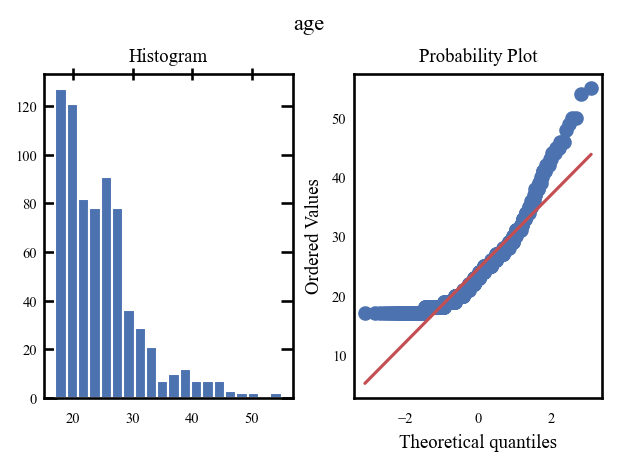

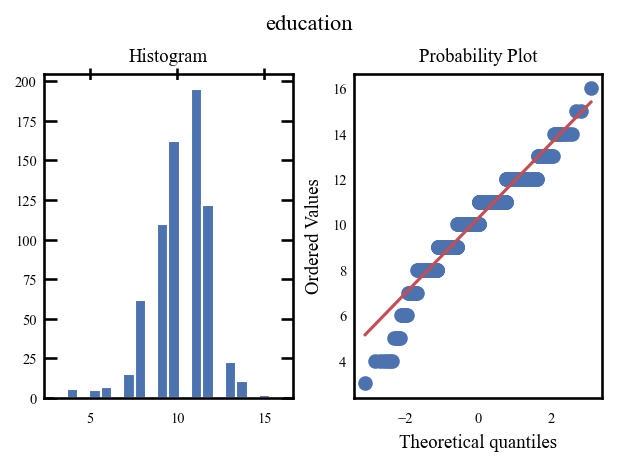

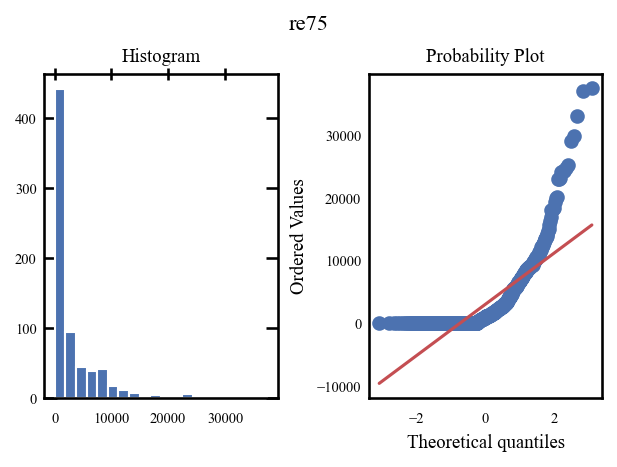

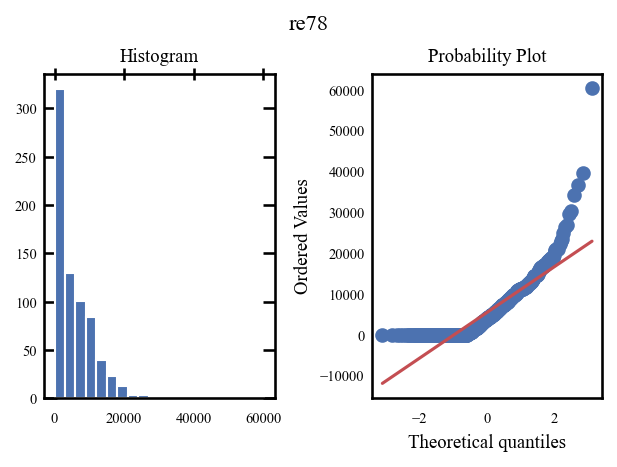

In [160]:
# QQ plots 
# Lalonde
plot_data(nsw,'age',"age")
plot_data(nsw,'education',"education")
plot_data(nsw,'re75',"re75")
plot_data(nsw,'re78',"re78")

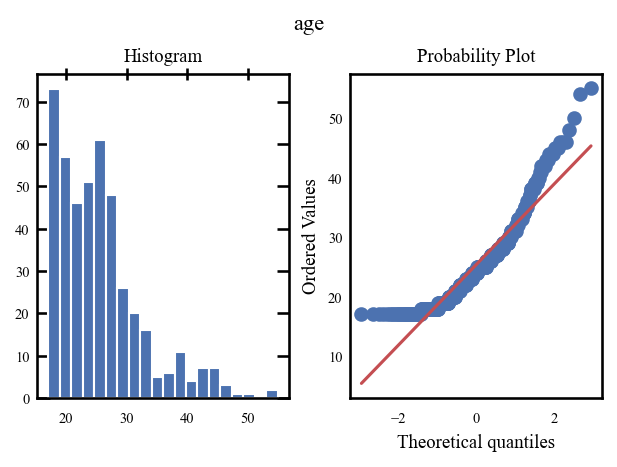

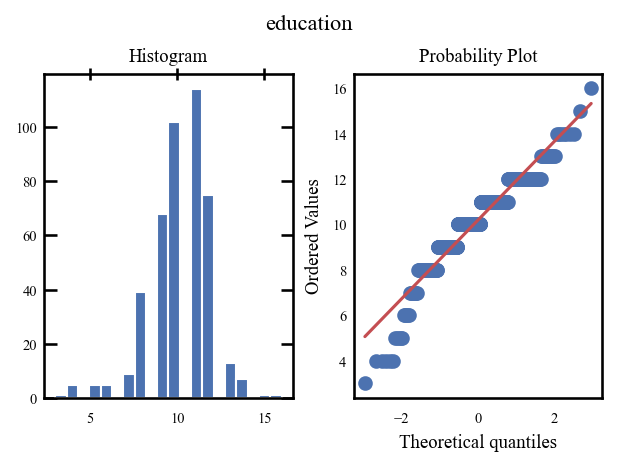

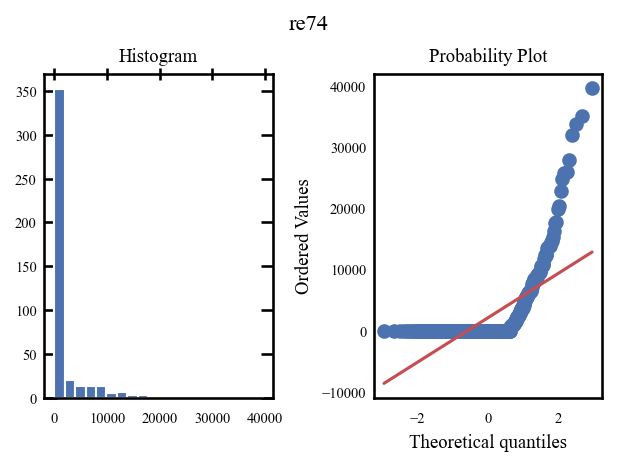

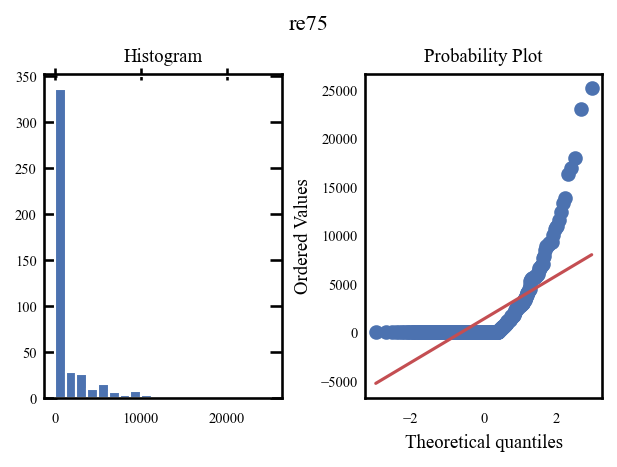

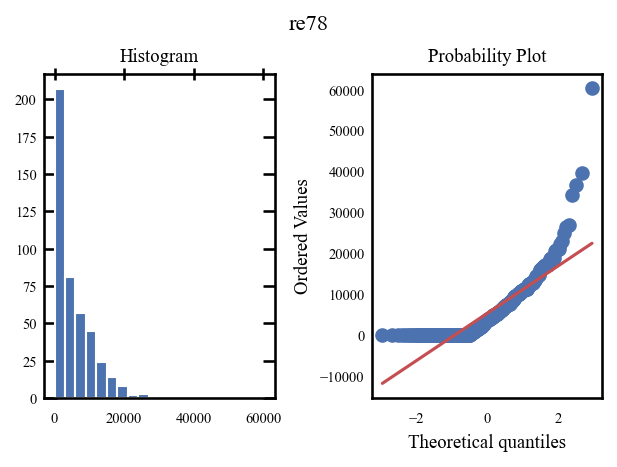

In [161]:
# QQ plots 
# Dehajia Wahba
plot_data(nswre74,'age',"age")
plot_data(nswre74,'education',"education")
plot_data(nswre74,'re74',"re74")
plot_data(nswre74,'re75',"re75")
plot_data(nswre74,'re78',"re78")

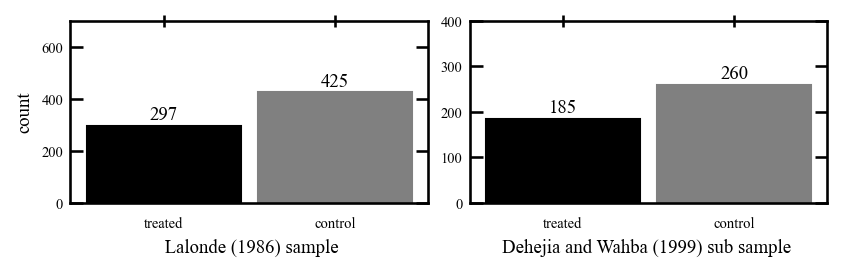

In [40]:
# Plot the balance of classes in the datasets 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)

nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated]) #Combine treatment into a single control as pandas dataframe

from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

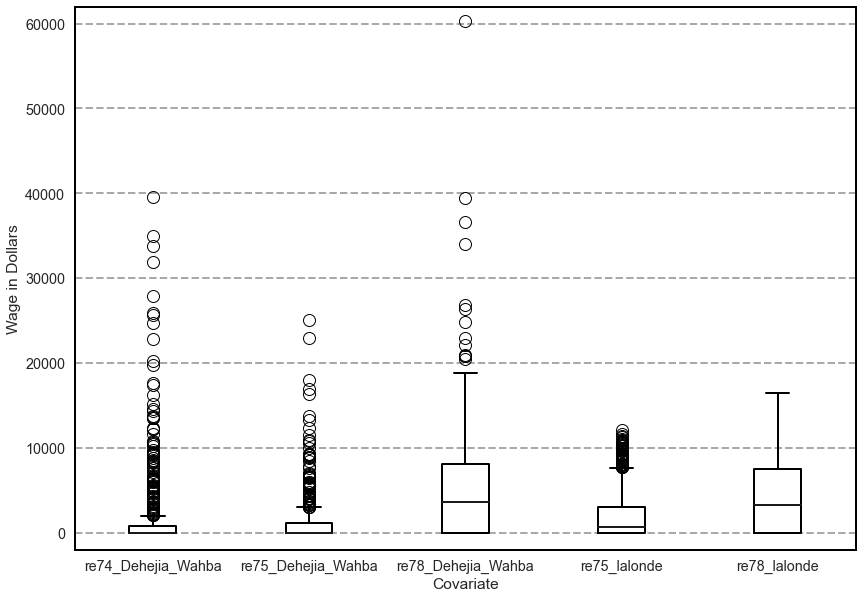

In [67]:
from tueplots import bundles 

fig, ax = plt.subplots(figsize=(14, 10))

plt.rcParams.update(bundles.neurips2022())



ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(2)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=2, alpha=1)

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 2, color='k')
boxprops = dict(linewidth = 2)
whiskerprops = dict(linewidth = 2)
capprops = dict(linewidth = 2)

flierprops = {'marker': 'o', 'markersize': 12,'linewidth':2}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['re74_Dehejia_Wahba', 're75_Dehejia_Wahba','re78_Dehejia_Wahba','re75_lalonde','re78_lalonde'])

ax.set_xlabel('Covariate')
ax.set_ylabel('Wage in Dollars')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_wage_boxplots.png', bbox_inches='tight')
plt.show()

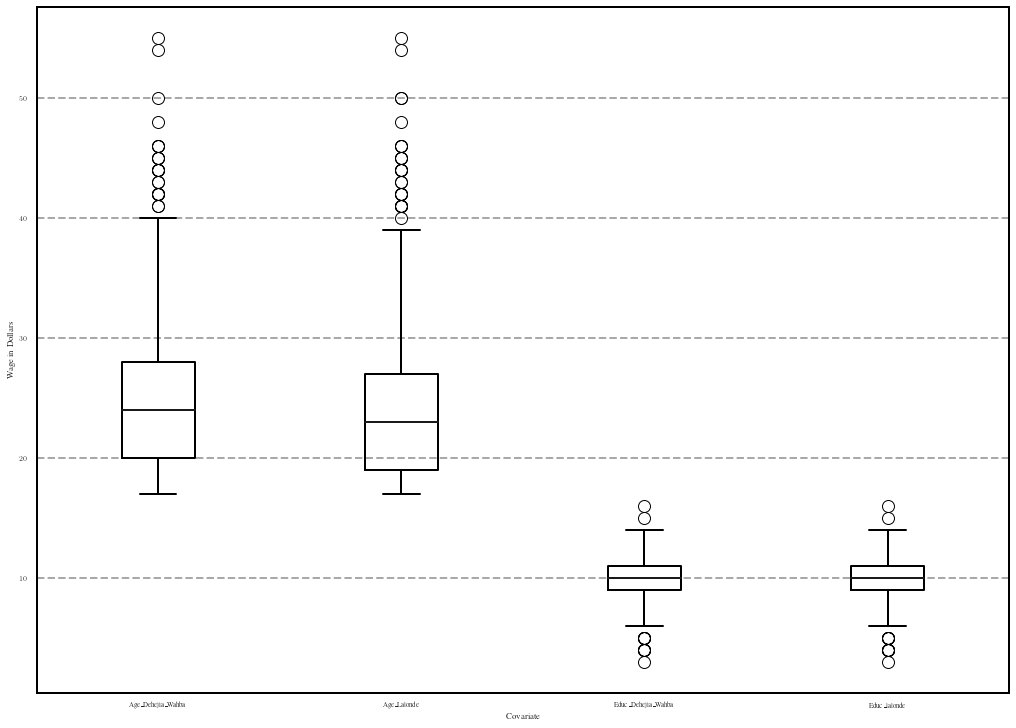

In [68]:
fig, ax = plt.subplots(figsize=(14, 10))

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(2)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=2, alpha=1)

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 2, color='k')
boxprops = dict(linewidth = 2)
whiskerprops = dict(linewidth = 2)
capprops = dict(linewidth = 2)

flierprops = {'marker': 'o', 'markersize': 12,'linewidth':2}

Age_dej = nswre74['age']
Educ_dej = nswre74['education']

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age_Dehejia_Wahba', 'Age_Lalonde','Educ_Dehejia_Wahba','Educ_lalonde'])


ax.set_xlabel('Covariate')

ax.set_ylabel('Wage in Dollars')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



### Remove outliers, transform variables and store dataset

In [153]:
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated]) #Combine treatment into a single control as pandas dataframe

In [154]:
# Drop outliers in the 95th percentile 
nsw.drop(nsw[nsw['re75'] > np.percentile(nsw['re75'] , 95)].index, inplace = True) 
nsw.drop(nsw[nsw['re78'] > np.percentile(nsw['re78'] , 95)].index, inplace = True) 

nswre74.drop(nswre74[nswre74['re74'] > np.percentile(nswre74['re74'] , 95)].index, inplace = True)
nswre74.drop(nswre74[nswre74['re75'] > np.percentile(nswre74['re75'] , 95)].index, inplace = True) 
nswre74.drop(nswre74[nswre74['re78'] > np.percentile(nswre74['re78'] , 95)].index, inplace = True) 


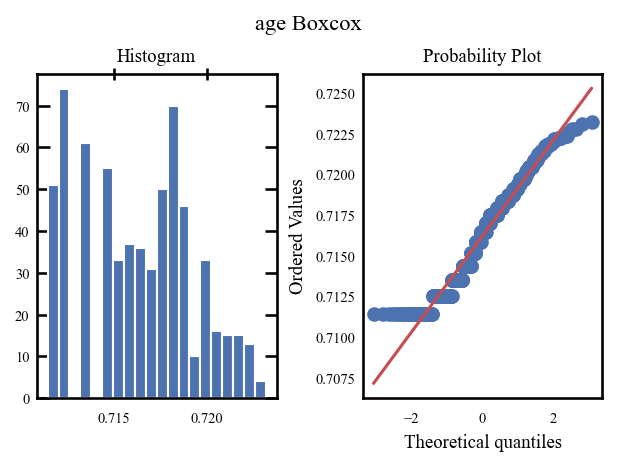

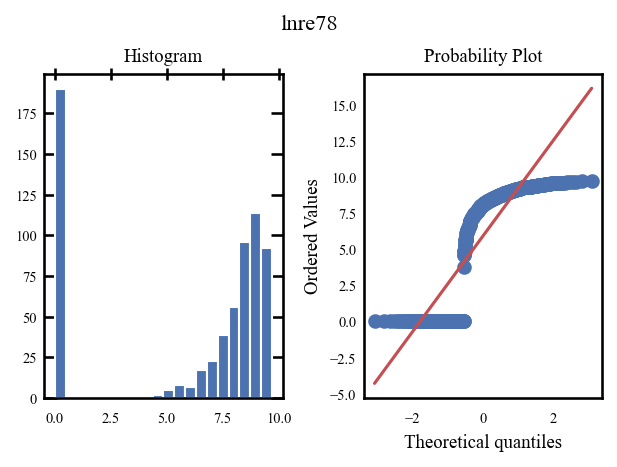

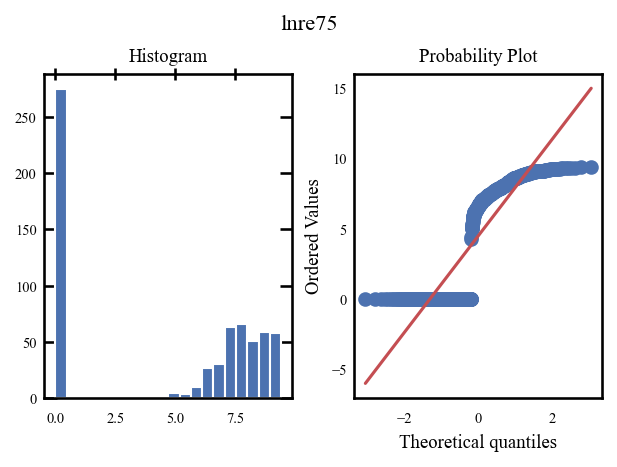

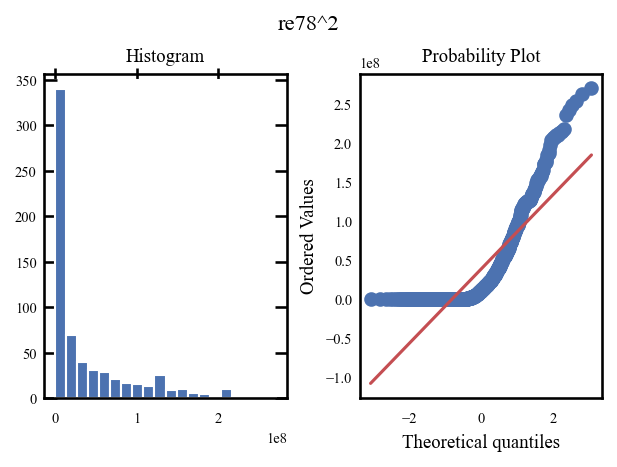

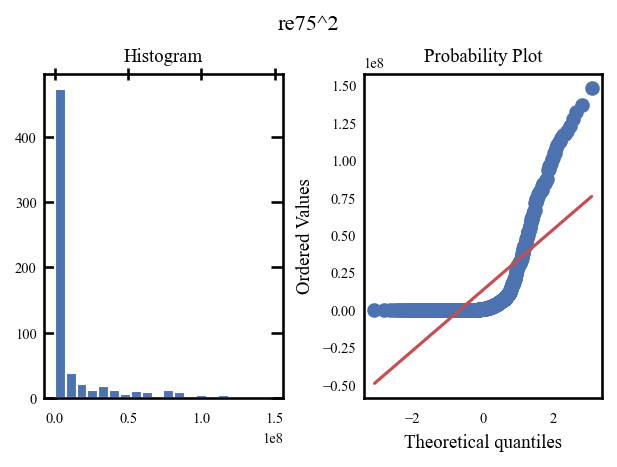

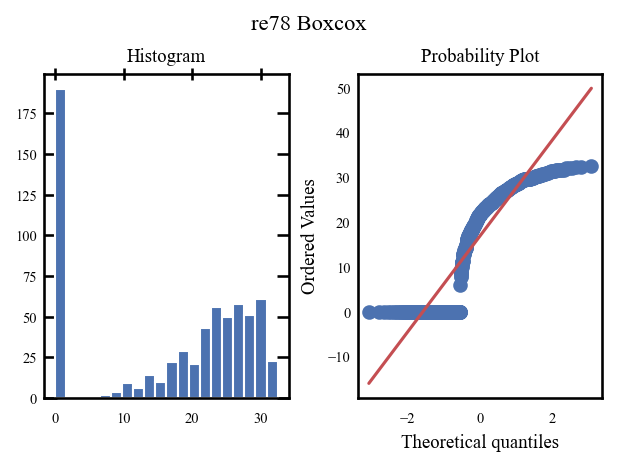

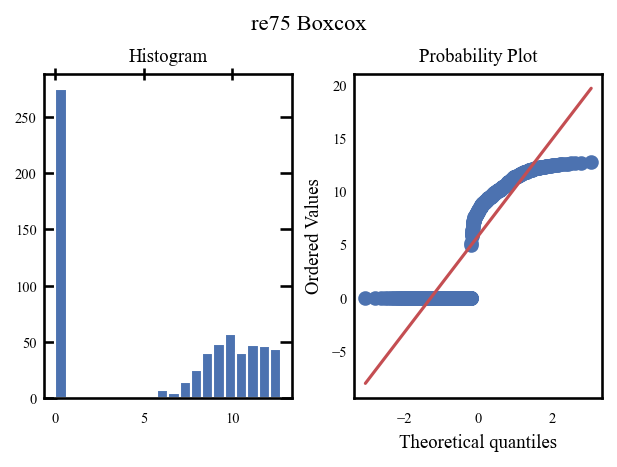

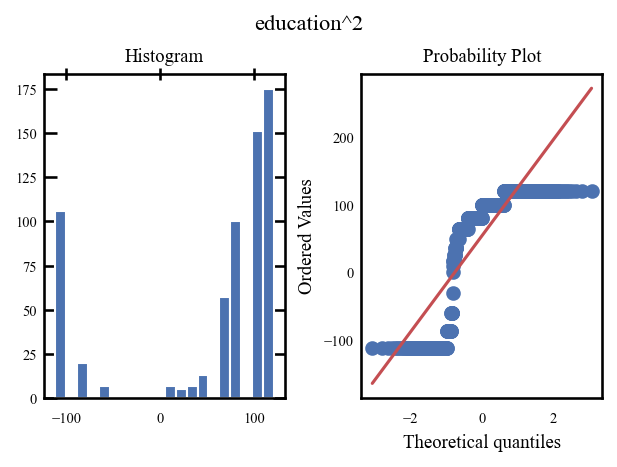

In [155]:
# Transformation of Lalonde original 
warnings.filterwarnings('ignore')

nsw['re78'][nsw['re78'] == 0] = 1
nsw['re75'][nsw['re75'] == 0] = 1

nsw['ageboxcox'],parameters=stat.boxcox(nsw['age'])

# Age squared
nsw['agesq'] = nsw['age']*nsw['age']

# boxcox transforms of varibles 
nsw['re78boxcox'],parameters=stat.boxcox(nsw['re78'])
nsw['re75boxcox'],parameters=stat.boxcox(nsw['re75'])

# natural logarith of wages 
nsw['lnre78'] = np.log(nsw['re78'])
nsw['lnre75'] = np.log(nsw['re75'])

#square of wages 
nsw['re78sq'] = nsw['re78']*nsw['re78']
nsw['re75sq'] = nsw['re75']*nsw['re75']

nsw['educsq'] = nsw['education']*nsw['education']

# Plot 
plot_data(nsw,'ageboxcox','age Boxcox')

plot_data(nsw,'lnre78','lnre78')
plot_data(nsw,'lnre75','lnre75')

plot_data(nsw,'re78sq','re78^2')
plot_data(nsw,'re75sq','re75^2')

plot_data(nsw,'re78boxcox','re78 Boxcox')
plot_data(nsw,'re75boxcox','re75 Boxcox')

plot_data(nsw,'educsq','education^2')



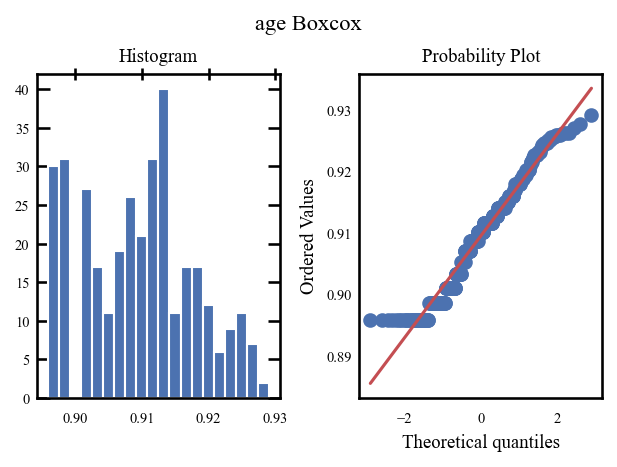

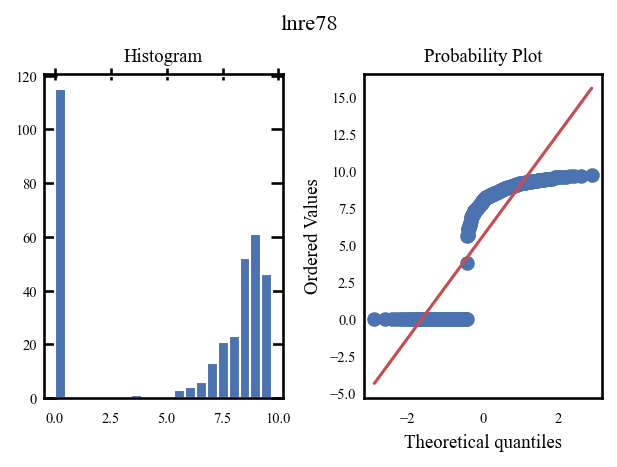

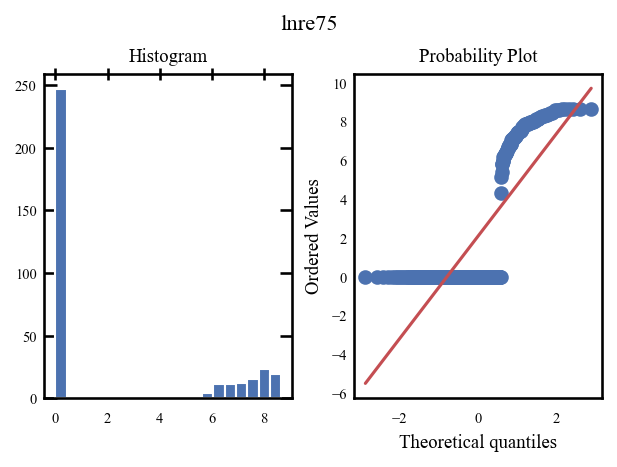

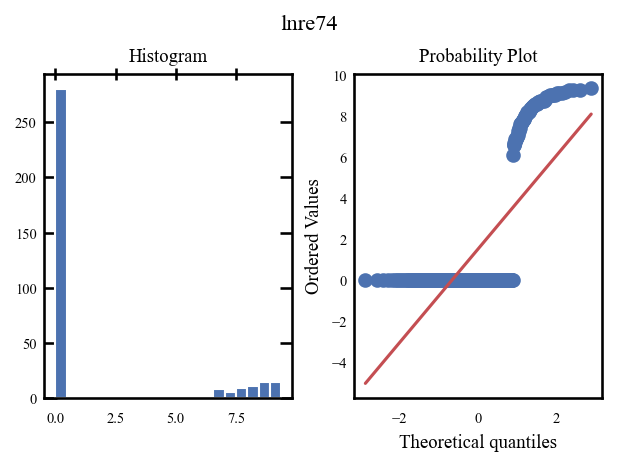

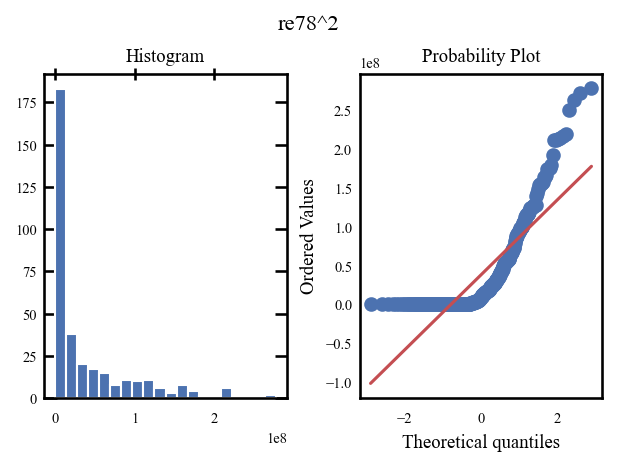

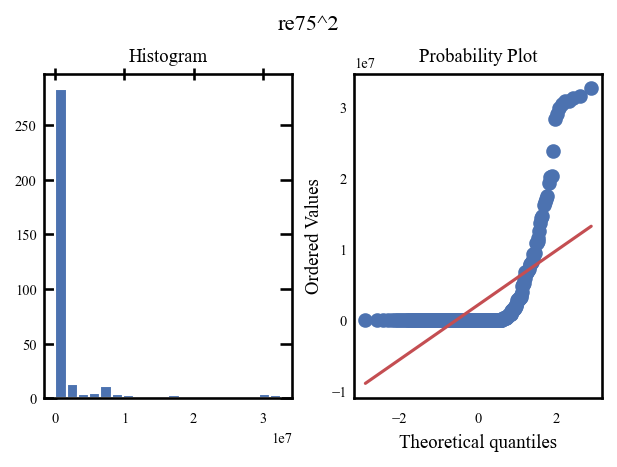

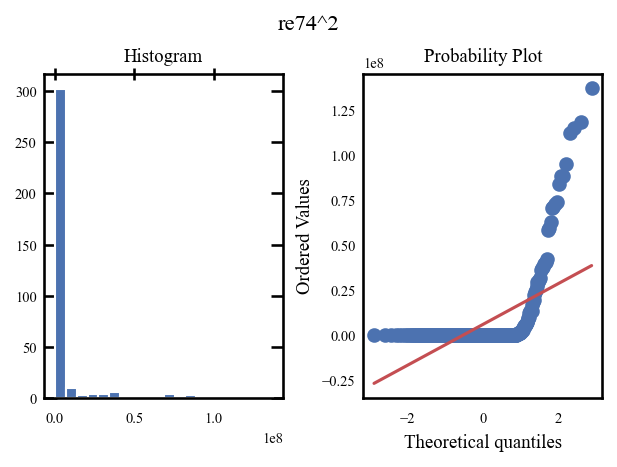

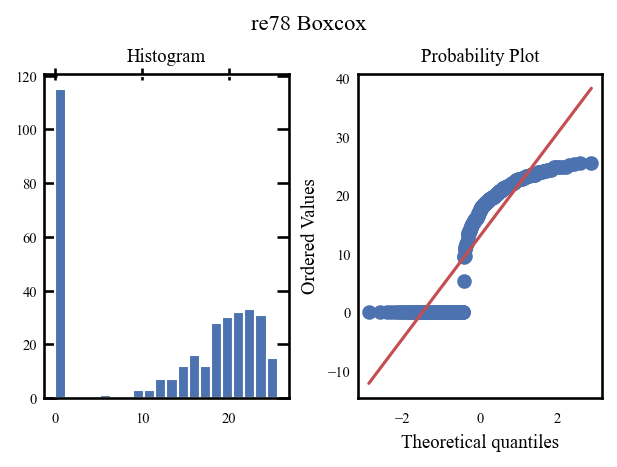

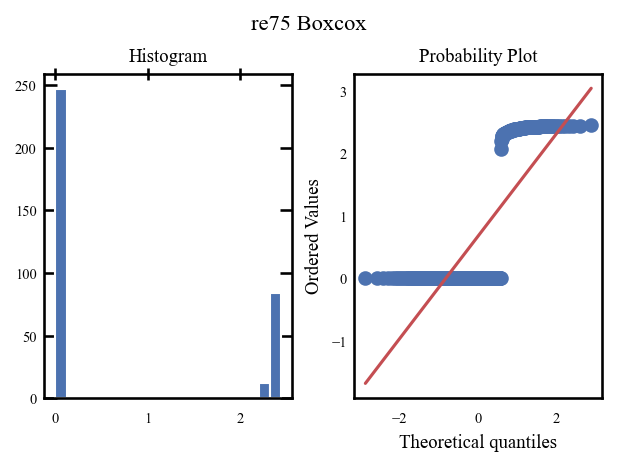

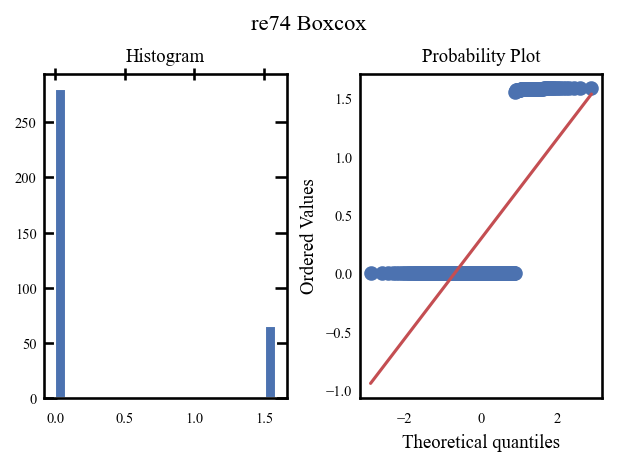

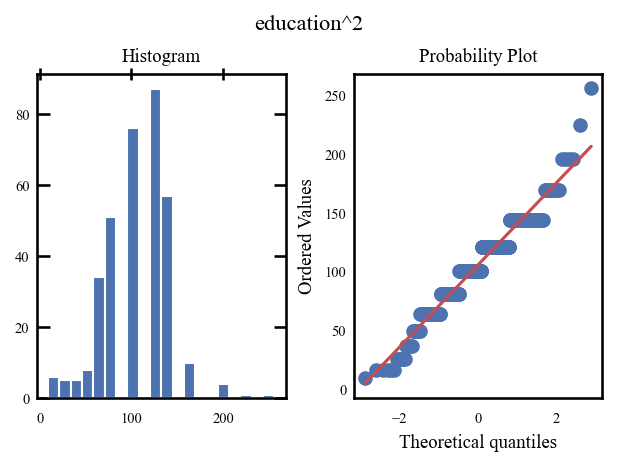

In [156]:
# Transformation of Lalonde original 
warnings.filterwarnings('ignore')

# Change zeroes to in wage as logs struggle
nswre74['re78'][nswre74['re78'] == 0] = 1
nswre74['re75'][nswre74['re75'] == 0] = 1
nswre74['re74'][nswre74['re74'] == 0] = 1


nswre74['ageboxcox'],parameters=stat.boxcox(nswre74['age'])

# Age squared
nswre74['agesq'] = nswre74['age']*nswre74['age']

# boxcox transforms of varibles 
nswre74['re78boxcox'],parameters=stat.boxcox(nswre74['re78'])
nswre74['re75boxcox'],parameters=stat.boxcox(nswre74['re75'])
nswre74['re74boxcox'],parameters=stat.boxcox(nswre74['re74'])

# natural logarith of wages 
nswre74['lnre78'] = np.log(nswre74['re78'])
nswre74['lnre75'] = np.log(nswre74['re75'])
nswre74['lnre74'] = np.log(nswre74['re74'])

#square of wages 
nswre74['re78sq'] = nswre74['re78']*nswre74['re78']
nswre74['re75sq'] = nswre74['re75']*nswre74['re75']
nswre74['re74sq'] = nswre74['re74']*nswre74['re74']

nswre74['educsq'] = nswre74['education']*nswre74['education']

# Plot 
plot_data(nswre74,'ageboxcox','age Boxcox')

plot_data(nswre74,'lnre78','lnre78')
plot_data(nswre74,'lnre75','lnre75')
plot_data(nswre74,'lnre74','lnre74')

plot_data(nswre74,'re78sq','re78^2')
plot_data(nswre74,'re75sq','re75^2')
plot_data(nswre74,'re74sq','re74^2')

plot_data(nswre74,'re78boxcox','re78 Boxcox')
plot_data(nswre74,'re75boxcox','re75 Boxcox')
plot_data(nswre74,'re74boxcox','re74 Boxcox')

plot_data(nswre74,'educsq','education^2')



### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (o mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

### Save datasets

In [162]:
nsw.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv',header = True,index = False)
nswre74.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv',header = True,index = False)

# PS estimating and Matching methods

In [130]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [35]:
# reload datasets for estimation and matching 
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74_treated.drop('treat', axis=1, inplace=True)

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
# drop control group (treat = 0)
nsw_treated = nsw[nsw['treat']==1]

cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps1.drop('data_id', axis=1, inplace=True)
cps1.drop('treat', axis=1, inplace=True)

psid1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid1.drop('data_id', axis=1, inplace=True)



# Logistic Regression 

In [36]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

(706, 9)


### Matching 1 - Artifical Neural networks 

#### define ANN class 

In [129]:
class twoLayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NameError: name 'nn' is not defined

In [16]:
# Data preprocessing for ANN 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Rescale continous variables for CPS data set 
cps1[['age','education','re74','re75','re78']] = sc.fit_transform(cps1[['age','education','re74','re75','re78']])
# Rescale continous variables for NSW data set 
nswre74_treated[['age','education','re74','re75','re78']] = sc.fit_transform(nswre74_treated[['age','education','re74','re75','re78']])
# Convert features into tensors for ANN 
# CPS dataset 
features_df_cps = cps1
features_array_cps = np.array(features_df_cps)
FEATURES_cps = torch.tensor(features_array_cps)
#NSW dataset 
features_df_nsw = nswre74_treated
features_array_nsw = np.array(features_df_nsw)
FEATURES_nsw = torch.tensor(features_array_nsw)
FEATURES_nsw = FEATURES_nsw.float()


In [17]:
# Neural netowrk hyper paramaters 
NUM_FEATURES = FEATURES_cps.shape[1]
NUM_HIDDEN_1 = 500
NUM_HIDDEN_2 = 250
NUM_HIDDEN_3 = 50
NUM_HIDDEN_4 = 25 
NUM_HIDDEN_5 = 12            
NUM_CLASSES = 1
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.0001

In [18]:
# Load saved model
model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.load_state_dict(torch.load('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/k_cross_ANN.pt'))

<All keys matched successfully>

In [19]:
# Predict propensity scores for CPS and NSW data 
with torch.no_grad():
    model.eval()
    prediction_cps = model(FEATURES_cps)
    prediction_nsw = model(FEATURES_nsw)

prediction_cps = pd.DataFrame(prediction_cps.float().numpy())
prediction_nsw = pd.DataFrame(prediction_nsw.float().numpy())    

In [20]:
# Append predicted PS to dataframes
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx') 
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps1.drop('data_id', axis=1, inplace=True)

nsw_with_ps = pd.concat([nswre74_treated,prediction_nsw],axis=1)
cps_with_ps = pd.concat([cps1,prediction_cps],axis=1)

nsw_with_ps.rename(columns = {0:'propensity_score'}, inplace = True)
cps_with_ps.rename(columns = {0:'propensity_score'}, inplace = True)
# Calculate the logit of the propensity score
nsw_with_ps['propensity_logit'] = np.log(nsw_with_ps['propensity_score'] / (1-nsw_with_ps['propensity_score']))
cps_with_ps['propensity_logit'] = np.log(cps_with_ps['propensity_score'] / (1-cps_with_ps['propensity_score']))

# Combine two dataframes 
nsw_cps_with_ps  = pd.concat([nsw_with_ps,cps_with_ps],axis=0,ignore_index = True)
#nsw_cps_with_ps['id'] = range(1, len(nsw_cps_with_ps) + 1)

In [21]:
# Remove observations which lie outside min and max estimated propesnity scores 
#max = nsw_cps_with_ps[nsw_cps_with_ps['treat']==1]['propensity_score'].max()
#min = nsw_cps_with_ps[nsw_cps_with_ps['treat']==1]['propensity_score'].min()
#nsw_cps_with_ps = nsw_cps_with_ps.drop(nsw_cps_with_ps[(nsw_cps_with_ps['propensity_score'] > max) | (nsw_cps_with_ps['propensity_score'] < min)].index)
#nsw_cps_with_ps

(0.0, 0.1)

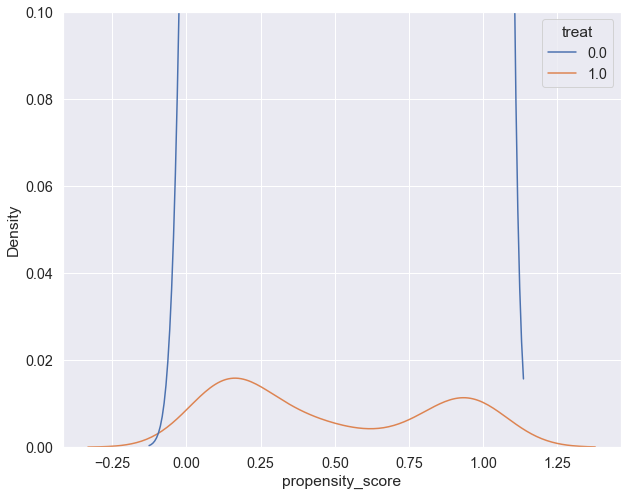

In [22]:
# Check overlap beteen groups
sns.kdeplot(data=nsw_cps_with_ps,x= 'propensity_score', hue= 'treat') 
plt.ylim(0,0.1)

### nearest-neighbour matching

In [44]:
from sklearn.neighbors import NearestNeighbors

caliper = np.std(nsw_cps_with_ps.propensity_score) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 20
# knn setup 
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
ps = nsw_cps_with_ps[['propensity_score']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0788


NearestNeighbors(n_neighbors=20, radius=0.07882174849510193)

In [45]:
#Matching loop

# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control
distances, neighbor_indexes = knn.kneighbors(ps)
matched_control = []  # keep track of the matched observations in control
neighbours = {} # store ID of matched neighbours to each control 
for current_index, row in nsw_cps_with_ps.iterrows():  # iterate over the dataframe
    if row.treat == 0:  # the current row is in the control group
        nsw_cps_with_ps.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (nsw_cps_with_ps.loc[idx].treat == 0):
                #print(f'treatd id : {current_index} | 'f' matched neighbours : {neighbor_indexes[current_index]} ')
                if idx not in matched_control:  # this control has not been matched yet
                    nsw_cps_with_ps.loc[current_index,'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    neighbours[current_index] = neighbor_indexes[current_index]
                    break

In [46]:
print('total observations in treatment:', len(nsw_cps_with_ps[nsw_cps_with_ps.treat==1]))
print('total matched observations in control:', len(neighbours))

total observations in treatment: 185
total matched observations in control: 185


In [47]:
# Create control group for unit's in matched keys
matched_controls = []
for idx in neighbours.values():  # iterate over the dataframe
    for i in idx:
        matched_controls.append(nsw_cps_with_ps.iloc[i])

matched_controls = pd.DataFrame(matched_controls)
(matched_controls.treat == 0).sum(axis=0) # count number of matched control units 
matched_controls = matched_controls[matched_controls['treat']==0]
matched_controls.drop('matched',axis=1, inplace=True)
len(matched_controls)

3435

In [48]:
# generate dataframe with treated and matchd control units 
matched_df = pd.concat([nsw_with_ps,matched_controls])
len(matched_df)
#dataframe before matching for comparison 
before_matched_df = pd.concat([nswre74_treated,cps1])
matched_df = pd.concat([nsw_with_ps,matched_controls],ignore_index=True)
matched_df

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.046000,0.196479,-1.408446
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,0.000000,3595.894000,0.110948,-2.081095
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,24909.450000,0.999728,8.207772
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,7506.146000,0.108633,-2.104777
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,289.789900,0.130304,-1.898275
...,...,...,...,...,...,...,...,...,...,...,...,...
3615,0.0,40.0,16.0,0.0,0.0,1.0,0.0,25862.320312,25243.550781,25564.669922,0.993492,5.028167
3616,0.0,40.0,16.0,0.0,0.0,1.0,0.0,25862.320312,25243.550781,25564.669922,0.993492,5.028167
3617,0.0,40.0,16.0,0.0,0.0,1.0,0.0,25862.320312,25243.550781,25564.669922,0.993492,5.028167
3618,0.0,27.0,12.0,0.0,0.0,1.0,0.0,14812.059570,17670.480469,25564.669922,0.993490,5.027955


In [49]:
# sava dataset to a csv file 
matched_df.to_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/lalonde_synthetic_control.csv")

<p> test distributions</p>

<p> plot distribtions of key variables pre and post matching </p>

(-10000.0, 45000.0)

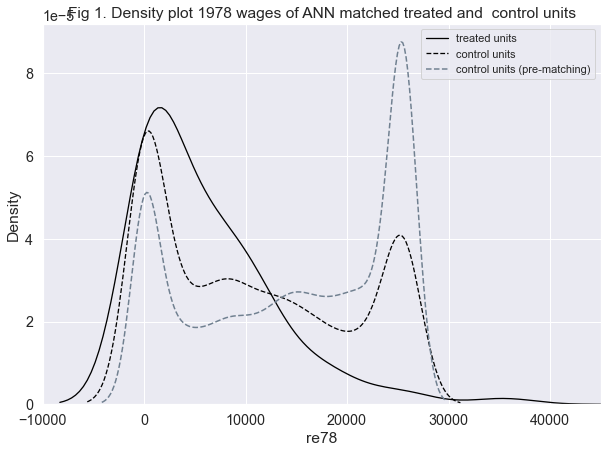

In [50]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['re78'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['re78'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
plt.title('Fig 1. Density plot 1978 wages of ANN matched treated and  control units')
# Density plots pre-matching
sns.kdeplot(before_matched_df['re78'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.legend(fontsize=11,loc = 1)
plt.xlim([-10000, 45000])



(2.0, 21.0)

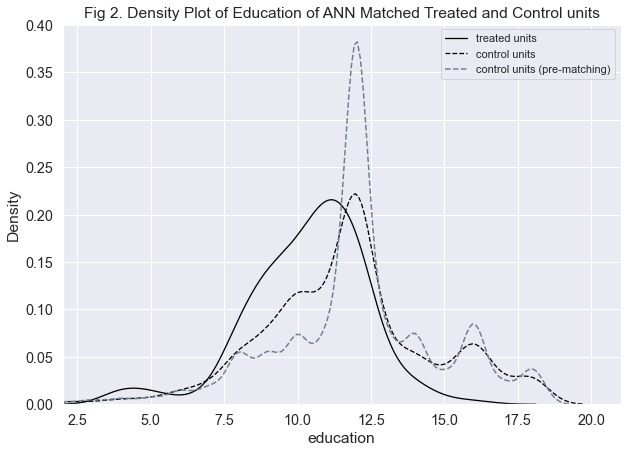

In [51]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['education'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['education'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
sns.kdeplot(before_matched_df['education'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')
plt.title('Fig 2. Density Plot of Education of ANN Matched Treated and Control units')
plt.legend(fontsize=11,loc = 1)
plt.xlim([2, 21])

### Matching 2 - logistic regression